<h1>University of Illinois DAS-sonde</h1>
<h3>Written by Stephen Nesbitt and Anna Nesbitt<br>
Last revision: 12.13.19</h3> 
<p>A Python script calling the metpy package to plot a SkewT for data collected with the University of Illinois Department of Atmospheric Sciences InterMet sounding system.</p>

In [2]:
# Install the required packages especially if using Google Colaboratory
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geos
!pip install pyproj
!pip install cython
!pip install pyshp
!pip install shapely
!pip install cartopy==0.16.0
!pip install metpy
!pip install gdown


Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 232 kB in 1s (250 kB/s)
Selecting previously unselected package libproj-dev:amd64.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../libproj-dev_4.9.3-2_amd64.deb ...
Unpacking libproj-dev:amd64 (4.9.3-

In [4]:
# Import some packages and methods
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from metpy.calc import dewpoint_rh
from matplotlib.pyplot import imread

# Loading Sounding Data from GitHub:
!wget  https://github.com/aenesbitt/DAS-sonde/raw/master/2019/121019_1900UTC.txt

# For files on Google Drive and the Block-I:
import gdown
my_file_id = "1fYOcbWmqqDdJ-3GasbRR5_Txme57t9sU"
!gdown https://drive.google.com/uc?id={my_file_id}

--2019-12-13 16:53:04--  https://github.com/aenesbitt/DAS-sonde/raw/master/2019/121019_1900UTC.txt
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aenesbitt/DAS-sonde/master/2019/121019_1900UTC.txt [following]
--2019-12-13 16:53:05--  https://raw.githubusercontent.com/aenesbitt/DAS-sonde/master/2019/121019_1900UTC.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241638 (236K) [text/plain]
Saving to: ‘121019_1900UTC.txt’

121019_1900UTC.txt  100%[===================>] 235.97K  --.-KB/s    in 0.003s  

2019-12-13 16:53:05 (81.4 MB/s) - ‘121019_1900UTC.txt’ saved [241638/241638]

Downloading...
From:

In [0]:
# Load data into pandas dataframe
filename = '121019_1900UTC.txt'
df = pd.read_table(filename, encoding = "ISO-8859-1", skiprows=[2], delim_whitespace=True, comment="#")
df=df.drop([0])


In [0]:
# Calculations
p = df['Press'].values.astype('float') * units.hPa
T = df['Temp'].values.astype('float') * units.celsius
Td = dewpoint_rh(df['Temp'].values.astype('float')*units.celsius, df['RelHum'].values.astype('float')/100.)
wind_speed = df['WSpeed'].values.astype('float') * units('m/s').to(units.kt)
wind_dir = df['WDirn'].values.astype('float') * units.degrees
z = df['GPM_AGL'].values.astype('float') * units.meters
u, v = mpcalc.wind_components(wind_speed, wind_dir)

Populating the interactive namespace from numpy and matplotlib


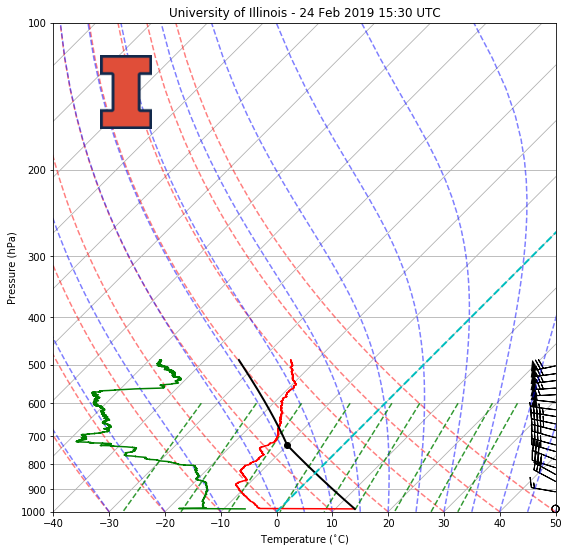

In [26]:
%pylab inline

fig = plt.figure(figsize=(9, 9))
#add_metpy_logo(fig, 115, 100)
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::120], u[::120], v[::120])
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 50)
skew.ax.set_xlabel('Temperature ($^{\circ}$C)')
skew.ax.set_ylabel('Pressure (hPa)')
# Calculate LCL height and plot as black dot
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.title('University of Illinois - 24 Feb 2019 15:30 UTC')

logo = imread('Illinois_Block_I.png')

fig.figimage(logo, 100, 425, zorder=10)

# Show the plot
plt.savefig(filename[:-4] + '_sounding.pdf')